#####  Solar Simulator IV sweep

##### Versions:

##### V2:       for both single sweep PV testing and multi-sweep degradation testing.
##### V3:       Added: lamp intensity parameter; manual lamp control options;  MPP tracking.
##### V4_Super: Semi-automated data upload to Dataverse.

#### Instructions and update notes:



To prepare, check the following:

* Turn the Keithley 2401 meter on and plug the KUSB488 into the USB hub.
* Also plug the Labjack unit into the USB hub and the FIO4 output of the Labjack to the trigger of the LSH-7320.
* Plug the USB hub into your computer.  Make sure each USB channel is on and each device mounts.

Some specifics of the code:

* Use the OS commands below to navigate to the directory where you want to save the data.
* Put this script and the K2401SS_4_1.py library in the current working directory (cwd).
* If you are not sure what the cwd is, use ```os.getcwd()``` to find out. ```%pwd``` also returns the cwd.
* The Operator name should be added manually in cell 3.a.1.
* Run cell 3.a.1.  Change the sample name, cell number, etc. as needed.  Press the green 'Submit' button after each update.
* Confirm your form selections in cell 3.a.2 before running 3.a.3. Cell 3.a.3 checks to make sure the sample is in the database.
* Cell 3.b.1 contains additional parameters to set manually.  
* Run code block 3.b.3 below. A "\data_mmddyy" directory will be automatically created within the cwd.
* Run code block 4.1: ```Keithley = K2401SS_4_1.K2401(dll_dir=dll_dir, GPIB_channel=GPIB_channel))``` 
    * If the Keithley unit is found it returns: ```KEITHLEY INSTRUMENTS INC.,MODEL 2401,1370363,A01 Aug 25 2011 12:57:43/A02  /S/K```
* The main script is in cell 5.1.
* The data is automatically saved in .csv files and a plot generated/saved after each sweep. 
* A time code (HHMMSS) is appended to the sample name to avoid overwiting the data from the same sample and cell.
* A parameters file is created and added to for each "\data" folder.

Path and filename:
* The path to the data folder is ```path = dir_path_local + "_" + today.strftime("%m%d%y")```  
* There are three kinds of files associated with each scan. Their names are built from the sample name, the cell number, the scan direction ("F" or "R"), and the time (HHMMSS).  The parameters file name has the date appended (mmddyy).
* A special timeseries parameter file is created for timeseries scans, as described below.

Sample and cell parameters:
* ```samplename = "Silicon"``` Name of you sample.
* ```cellnumber = "1"```       Cell number (in string format).
* ```cellarea = 2.0*4.0```     Cell area or mask area in cm$^2$.

Voltage sweep parameters:
* ```startv = -0.1```         Sweep start voltage.
* ```stopv = 0.65```          Sweep stop voltage.
* ```stepv = 0.025```         Sweep step size.
* ```sweep_rate = "medium"``` slow=about 1.3 steps/s, medium=5 steps/s,fast=12 steps/s. Note that ```stepv``` also affects the sweep rate in mV/s.
* ```direction = "both"``` options are: ("forward", "reverse", and "both"). Selecting "both" results in four sweeps since dark and light sweeps are done in each direction. Selecting "forward" or "reverse" result in two sweeps, one dark and one light.

Single scan option:
* ```do_single_scan = True``` (True/False) Single scan takes priority. Set this option to ```False``` to run a timeseries or MPP.
* Set the other parameters in code block 9 as needed.
* Pro Tip: It may be more convenient to use "Restart & Run All" from the Kernel menu after updating the parameters instead of executing each cell individually.

Multiple sweeps for degradation testing:

* Set ```do_timeseries = True``` and ```do_single_scan = False```.
* Set the other parameters in code block 9 as needed.
* Use the companion script "IV_sweep_Timeseries_Monitor_V1.ipynb" to view a continually updated plot of the timeseries.
    * Make sure the ```path``` and ```filename``` variables are set correctly. 
    * The filename should have the form "timeseries_parameters_mmddyy". It will be automatically created by this script.

Timeseries loop options:
* ```do_timeseries = False```         (True/False) Set this option to ```True``` to run a time series.
* ```timeseries_interval = int(60)``` interval in seconds. (must be an integer)
* ```timeseries_duration = 1.0```     duration in hours. (float)

Saving and printing options:
* ```savedata = 'yes'```       ('yes'/'no') Saves the data and the plot to a file.
* ```saveparameters = 'yes'``` ('yes'/'no') Adds the parameters to the parameters file.
* ```verbose = 1```            (1/0) Prints a lot of extra stuff and shows the plot.

For Labjack code examples, consult the source code at https://github.com/labjack/LabJackPython/blob/master/src/u

##### V2 last updated 1/1/2022 RLH.

##### V3 New capabilities

Lamp intensity parameters:
* ```I_ph = 1.00```            (normally 0.80-1.00) Correct for lamp intensity and spectral mismatch factors. 

Lamp control:
* ```labjack = True```       (True/False) Set to True to control the lamp with the LabJack U3 device.
* ```do_dark_sweep = True``` (True/False) Set to True to enable dark sweeps. If False they will be skipped and the lamp will always be on.
* ```burnintime = 10```      (Time in sec.) Burn in time in seconds with the lamp on before the sweep starts. 
 
Maximum power point tracking:
* ```mpp_tracking_mode = True```   (True/False) Set to True to set the voltage to mpp_V after each sweep.
* ```mpp_default  = "0.9"```       (Must be a string)  Intial guess for the mpp voltage. [Volts] 
* Make sure to set the ```do_single_scan``` parameter to ```False``` for MPP tracking mode.
* Also make sure that ```do_timeseries``` is set to ```True```.
* ```four_wire = False```     (True/False) Set this option to ```True``` for 4-wire mode.

The latest version of the K2401SS package is called ```K2401SS_4_1```, which is version 4.1.

##### V3 last updated on 12/30/2023 RLH.

##### V4_Super New capabilities.
* View a list of recent samples in the sample database and select the sample from a drop-down list.
* Save scan results to the J-V_Test_Data database.

Database and data folder parameters:
* ```dir_path_local = os.path.normpath(os.path.join(jupyter_notebook_path, "../Seid"))```  Sets the data folder name and the default Operator name.
* ```last_num= 5```                                                                        The number of Sample records to view, most recent first.

##### 1. Import the required packages and modules.

In [219]:
### 1.1 ###|
import os
from datetime import date, datetime
import time
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import sys
from IPython.display import display
from tqdm import tqdm
import subprocess
import re
import sys
import ipywidgets as widgets
import json
import warnings
warnings.filterwarnings('ignore')             # Supresses warnings for code I don't want to change.
import K2401SS_4_1                            # K2401 Solar Simulator module 2-wire and 4-wire with MPP.
from db_form import parameters_form           # Yoni's form code.
from db_dataverse import SampleDataverseTable # Dataverse code based on scripts by Felix.
from db_dataverse import JVScanDataverseTable # 

##### 2. View a list of samples in the Sample Database.

In [220]:
### 2.1 ###
# Everything should be relative to jupyter_notebook_path.  
# There will be other folders created,such as ../{operator}_{date}
jupyter_notebook_path = os.getcwd()
%pwd

'C:\\Users\\LabUser\\OneDrive - Verde Technologies\\Documents\\data2\\K2401SSDB'

In [221]:
### 2.2 ###
# Database parameters.

# It may be necessary to use the 'Connect' command in Powershell to change the user before running this cell.
#crm_url =  "https://orgc25b23b3.api.crm.dynamics.com/"        # Randall Headrick's Environment at UVM.
crm_url = "https://perovskitedevelop.api.crm.dynamics.com/"    # Perovskite Data Developer Environment at VerdeTechnologies. 

#sample_table_logical_name =  "cr69a_sampledatav2s"
sample_table_logical_name =  "crf3d_sample_datas"               # Perovskite Data Developer, Dataverse table.

#JV_scan_table_logical_name = "cr69a_jv_test_data_v3s"
JV_scan_table_logical_name = "crf3d_jv_test_datas"              # Perovskite Data Developer, Dataverse table.

# This is not a complete list, only a few that might be helpful to identify the sample.
Sample_table_logical_names = {
    "Sample ID": 'crf3d_sampleid', 
    "Operator": 'crf3d_operatorname', 
    "Perovskite Composition": 'crf3d_perovskitecomposition', 
    "HTL Material": 'crf3d_htlmaterial', 
    "ETL Material": 'crf3d_etlmaterial',
    "Top Capping Material": 'crf3d_topcappingpassivationmaterial', 
    "Bottom Capping Material": 'crf3d_bottomcappingpassivationmaterial', 
    "Bulk Passivation Materials": 'new_bulkpassivationmaterial', 
    "Is Encapsulated": 'crf3d_isencapsulated'
}
 
# View a list of samples in the database.
last_num= 80  ################### The number of Sample records to view, most recent first.############
sample_table = SampleDataverseTable(crm_url, sample_table_logical_name, col_logical_names=Sample_table_logical_names)
sample_ids, recent_values, result = sample_table.recent_entries(last_num)
print(sample_ids)
recent_values

# Columnn logical names. # 23 parameters in the correct order.  They will be uploaded to the J-V_test_data_V3 table.
# For J-V_Scan_Data_V3
# col_logical_names = {
#     'sample_id': 'cr69a_sample_id',
#     'elapsed_time': 'cr69a_elapsed_time_sec',
#     'base_time': 'cr69a_base_time_sec',  # New base_time value.
#     'test_id': 'cr69a_test_id',
#     'i_ph_suns': 'cr69a_iph_suns',
#     'voc_v': 'cr69a_voc_v',
#     'mpp_v': 'cr69a_mpp_v',
#     'jsc_ma': 'cr69a_jsc_macm2',
#     'rsh': 'cr69a_rsh',
#     'rser': 'cr69a_rser',
#     'ff': 'cr69a_ff_pct',
#     'pce': 'cr69a_pce_pct',
#     'operator': 'cr69a_operator_name',
#     'scan_type': 'cr69a_scan_type',
#     'lab_location': 'cr69a_location',
#     'cell_number': 'cr69a_cell_number',
#     'module': 'cr69a_module',
#     'masked': 'cr69a_masked',
#     'mask_area': 'cr69a_mask_area_cm2',
#     'temp_c': 'cr69a_temperature_c',  # New.
#     'hum_pct': 'cr69a_humidity_pct', # New.
#     'four_wire_mode': 'cr69a_four_wire_mode', # New.
#     'scan_data_path': 'cr69a_scan_path' # New.
# }
# image_column_name = 'cr69a_scan_image'  # Optional column.

# For J-V_Scan_Data on  Perovskite Data Developer, Verde Technologies.
col_logical_names = {
    'sample_id': 'crf3d_sample_id',
    'elapsed_time': 'crf3d_elapsed_time_sec',
    'base_time': 'crf3d_base_time_sec',  # New base_time value.
    'test_id': 'crf3d_test_id',
    'i_ph_suns': 'crf3d_iph_suns',
    'voc_v': 'crf3d_voc_v',
    'mpp_v': 'crf3d_mpp_v',
    'jsc_ma': 'crf3d_jsc_macm2',
    'rsh': 'crf3d_rsh',
    'rser': 'crf3d_rser',
    'ff': 'crf3d_ff_pct',
    'pce': 'crf3d_pce_pct',
    'operator': 'crf3d_operator_name',
    'scan_type': 'crf3d_scan_type',
    'lab_location': 'crf3d_location',
    'cell_number': 'crf3d_cell_number',
    'module': 'crf3d_module',
    'masked': 'crf3d_masked',
    'mask_area': 'crf3d_mask_area_cm2',
    'temp_c': 'crf3d_temperature_c',  # New.
    'hum_pct': 'crf3d_humidity_pct', # New.
    'four_wire_mode': 'crf3d_four_wire_mode', # New.
    'scan_data_path': 'crf3d_scan_path' # New.
}
image_column_name = 'new_jv_scan_plot'  # Optional column.

# Set up the J-V_Test_Data table.
jv_test_table = JVScanDataverseTable(crm_url=crm_url, table_name=JV_scan_table_logical_name)

recent_values

['04112025_FAPI_SA_SS_IZO_Cu(20nm)_C2', '04112025_FAPI_SA_SS_IZO_Cu(20nm)_C1', '040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C4', '040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C3', '040325_FAPI_SA_SnOx_Cu_C2', '040325_FAPI_SA_SnOx_Cu_C1', '040325_PC62R04_AB302_Dev9', '040325_PC62R04_AB302_Dev3', '040325_PC62R04_AB313_Dev8', '040325_PC62R04_AB313_Dev7', '040325_PC62R04_AB341_Dev4', '040325_PC62R04_AB341_Dev6', '040325_PC62R04_PNY1890714_Dev2', '04032025_PanacolY1890714_DEV1', '040225_FTO_Spider_encapsulation_RFP_dev1', '033125_FTO_Spider_encapsulation_RFP_dev2', '033125_FTO_Spider_encapsulation_RFP_dev1', '03272025_FAPI_SA_Sofab_C2', '03272025_FAPI_SA_Sofab_C1', 'dev1', '031725_FAPI_SA_Control_20nm_Cu_C9', '031725_FAPI_SA_SS_Plates_20nm_Cu_C8', '031725_FAPI_SA_SS_Plates_20nm_Cu_C7', '031725_FAPI_SA_SS_Plates_20nm_Cu_C6', '031725_FAPI_SA_SS_Plates_20nm_Cu_C5', '031725_FAPI_SA_SS_Plates_20nm_Cu_C4', '031725_FAPI_SA_SS_Plates_20nm_Cu_C3', '031725_FAPI_SA_SS_Plates_20nm_Cu_C2', '031725_FAPI_SA_SS_Plates_20nm

,Sample ID,Operator,Perovskite Composition,HTL Material,ETL Material,Top Capping Material,Bottom Capping Material,Bulk Passivation Materials,Is Encapsulated
0,04112025_FAPI_SA_SS_IZO_Cu(20nm)_C2,Pramod,CsFAPI,NiOx,C60/BCP,3MTPAI,DPPP,"[""FACl""]",True
1,04112025_FAPI_SA_SS_IZO_Cu(20nm)_C1,Pramod,CsFAPI,NiOx,C60/BCP,3MTPAI,DPPP,"[""FACl""]",True
2,040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C4,Pramod,CsFAPI,MeO-4PAcZ (1.0 mM),C60/SnOx_Nd,3MTPAI,PEAI,"[""FACl""]",True
3,040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C3,Pramod,CsFAPI,MeO-4PAcZ (1.0 mM),C60/SnOx_Nd,3MTPAI,PEAI,"[""FACl""]",True
4,040325_FAPI_SA_SnOx_Cu_C2,Pramod,CsFAPI,MeO-4PAcZ (1.0 mM),C60/SnOx,3MTPAI,PEAI,"[""FACl""]",True
...,...,...,...,...,...,...,...,...,...
75,261124_FAPI_SA_ITO_C3,Seid,CsFAPI,MeO-4PAcZ (1.0 mM),C60/SnOx,3MTPAI,PEAI,"[""FACl""]",True
76,261124_FAPI_SA_Cu10nm_ITO_C1,Seid,CsFAPI,MeO-4PAcZ (1.0 mM),C60/SnOx,3MTPAI,PEAI,"[""FACl""]",True
77,112524_FAPI_SA_ITO_NPs_4D_C60_BCP_Cu(20nm)_C2,Pramod,CsFAPI,NiOx,C60/BCP,3MTPAI,DPPP,"[""FACl""]",True
78,112524_FAPI_SA_ITO_NPs_4D_C60_BCP_Cu(20nm)_C1,Pramod,CsFAPI,NiOx,C60/BCP,3MTPAI,DPPP,"[""FACl""]",True


In [222]:
result

CompletedProcess(args='pwsh -ExecutionPolicy Bypass -File "C:\\Users\\LabUser\\OneDrive - Verde Technologies\\Documents\\data2\\K2401SSDB/scripts/recent-entries_V2.ps1" "crf3d_sample_datas"                "?$select=crf3d_sampleid,crf3d_operatorname,crf3d_perovskitecomposition,crf3d_htlmaterial,crf3d_etlmaterial,crf3d_topcappingpassivationmaterial,crf3d_bottomcappingpassivationmaterial,new_bulkpassivationmaterial,crf3d_isencapsulated&"$orderby"=createdon desc" 80 "https://perovskitedevelop.api.crm.dynamics.com/" -cols "crf3d_sampleid,crf3d_operatorname,crf3d_perovskitecomposition,crf3d_htlmaterial,crf3d_etlmaterial,crf3d_topcappingpassivationmaterial,crf3d_bottomcappingpassivationmaterial,new_bulkpassivationmaterial,crf3d_isencapsulated"', returncode=0, stdout='04112025_FAPI_SA_SS_IZO_Cu(20nm)_C2, Pramod, CsFAPI, NiOx, C60/BCP, 3MTPAI, DPPP, ["FACl"], True\n04112025_FAPI_SA_SS_IZO_Cu(20nm)_C1, Pramod, CsFAPI, NiOx, C60/BCP, 3MTPAI, DPPP, ["FACl"], True\n040325_FAPI_SA_20%_Nb_doped_SnOx_

##### 3(a). Scan parameters form.

In [223]:
### 3.a.1 ###
# Scan parameter form. Change the operator name in this code block.
#
os.chdir(jupyter_notebook_path)
# The questions json file can be anywhere, but it will usually be in the directory with this Notebook.
questions_file_main= os.path.join(jupyter_notebook_path, "main_questions.json")
# We will use the local directory path as the default value for the 'operator' question on the form.
dir_path_local = os.path.normpath(os.path.join(jupyter_notebook_path, "../Pramod"))  #<------------------- Add your name here!
form = parameters_form(persistent=True, dir_path_local=dir_path_local, 
                               questions_file_main=questions_file_main, drop_down_values=[sample_ids])
form.dropdown_values = sample_ids
print(form.dropdown_values)
form.display_question_canvas()

['04112025_FAPI_SA_SS_IZO_Cu(20nm)_C2', '04112025_FAPI_SA_SS_IZO_Cu(20nm)_C1', '040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C4', '040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C3', '040325_FAPI_SA_SnOx_Cu_C2', '040325_FAPI_SA_SnOx_Cu_C1', '040325_PC62R04_AB302_Dev9', '040325_PC62R04_AB302_Dev3', '040325_PC62R04_AB313_Dev8', '040325_PC62R04_AB313_Dev7', '040325_PC62R04_AB341_Dev4', '040325_PC62R04_AB341_Dev6', '040325_PC62R04_PNY1890714_Dev2', '04032025_PanacolY1890714_DEV1', '040225_FTO_Spider_encapsulation_RFP_dev1', '033125_FTO_Spider_encapsulation_RFP_dev2', '033125_FTO_Spider_encapsulation_RFP_dev1', '03272025_FAPI_SA_Sofab_C2', '03272025_FAPI_SA_Sofab_C1', 'dev1', '031725_FAPI_SA_Control_20nm_Cu_C9', '031725_FAPI_SA_SS_Plates_20nm_Cu_C8', '031725_FAPI_SA_SS_Plates_20nm_Cu_C7', '031725_FAPI_SA_SS_Plates_20nm_Cu_C6', '031725_FAPI_SA_SS_Plates_20nm_Cu_C5', '031725_FAPI_SA_SS_Plates_20nm_Cu_C4', '031725_FAPI_SA_SS_Plates_20nm_Cu_C3', '031725_FAPI_SA_SS_Plates_20nm_Cu_C2', '031725_FAPI_SA_SS_Plates_20nm

Output(layout=Layout(border='1px solid black', height='400px'))

Button(button_style='success', description='Submit', style=ButtonStyle())

Form responses: "['Pramod', '040325_FAPI_SA_SnOx_Cu_C1', [True, True, False], 'Upstairs (W426)', '1', 'No', 'No', '0.0', '0.805']"
Form responses: "['Pramod', '040325_FAPI_SA_SnOx_Cu_C1', [True, True, False], 'Upstairs (W426)', '1', 'No', 'No', '0.0', '0.805']"
Form responses: "['Pramod', '040325_FAPI_SA_SnOx_Cu_C1', [True, True, False], 'Upstairs (W426)', '2', 'No', 'No', '0.0', '0.805']"
Form responses: "['Pramod', '040325_FAPI_SA_SnOx_Cu_C1', [True, True, False], 'Upstairs (W426)', '2', 'No', 'No', '0.0', '0.805']"
Form responses: "['Pramod', '040325_FAPI_SA_SnOx_Cu_C1', [True, True, False], 'Upstairs (W426)', '3', 'No', 'No', '0.0', '0.805']"
Form responses: "['Pramod', '040325_FAPI_SA_SnOx_Cu_C1', [True, True, False], 'Upstairs (W426)', '5', 'No', 'No', '0.0', '0.805']"
Form responses: "['Pramod', '040325_FAPI_SA_SnOx_Cu_C1', [True, True, False], 'Upstairs (W426)', '6', 'No', 'No', '0.0', '0.805']"
Form responses: "['Pramod', '040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C3', [True, True, 

In [360]:
### 3.a.2 ###
# Check to make sure the form output is what you want. 
print(form.responses)

['Pramod', '040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C4', [True, True, False], 'Upstairs (W426)', '5', 'No', 'No', '0.0', '0.805']


In [361]:
### 3.a.3  ###
# Convert the form responses into a dictionary for easier indexing.
form_questions = [question['question'] for question in form.questions]
form_responses_dictionary = dict(zip(form_questions, form.responses))
print(form_responses_dictionary)

# Use the check_existence function of class DataverseTable to retrieve the cell area.
#table = SampleDataverseTable("cr69a_sampledatav2s")
samplename = form_responses_dictionary['Sample name? (must be a sample in the database)']
allow_entry, Sample_primary_ID, check_existence_result = sample_table.check_existence(samplename, require_confirmation=False)
#print(check_existence_result)
# The string manipulaton code below could fail if the list of headings to retrieve is changed in the check_existence() function. 
result_line  = check_existence_result.stdout.strip() 
string = re.split(r',', result_line)[-1]                # Assume that 'Cell_active_area' is after the last comma.
cell_area =  float(re.split(r':',string)[-1])           # Heading and value are separated by a colon.
print(f'cellarea = {cell_area} cm^2')                   # If this gives a crazy result, check the PowerShell output below.

{'Operator': 'Pramod', 'Sample name? (must be a sample in the database)': '040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C4', 'Scan types': [True, True, False], 'Where were the measurements done?': 'Upstairs (W426)', 'Cell number?': '5', 'Is this a module measurement?': 'No', 'Is the sample masked?': 'No', 'Mask area (cm^2)?': '0.0', 'Lamp intensity (suns)': '0.805'}

 PowerShell: Found the Sample_ID: '040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C4', 'Sample_data_ID': fbffa73b-b410-f011-998a-000d3a5a111e, 'Operator_name': Pramod, 'Created_on': 04/03/2025 17:51:13, 'Cell_active_area': 0.15 

cellarea = 0.15 cm^2


##### 3(b). Manually entered scan parameters.

In [362]:
### 3.b.1 ###
#####  Set additional parameters here. Excecute this code block to set the parameters. #####
#####  Then execute the cells below to run the scan.                                   #####
#
# Sample and cell parameters.
samplename = form_responses_dictionary['Sample name? (must be a sample in the database)']
cellnumber = form_responses_dictionary[ 'Cell number?']
if form_responses_dictionary['Is the sample masked?'] ==  'Yes':
    cellarea = float(form_responses_dictionary['Mask area (cm^2)?'])  # Used the masked area as the cell area.
else:
    cellarea = cell_area # cm^2                                # This value is retrieved from the sample database.

# Voltage sweep parameters.
startv = -0.25
stopv = 1.25
stepv = 0.02
sweep_rate = "fast"                                            # slow=about 0.9 steps/s, medium=3.5 steps/s,fast=14 steps/s (measured at 20 mV/step).

b0 = form_responses_dictionary['Scan types'][0]                # Options are: "forward", "reverse", and "both".
b1 = form_responses_dictionary['Scan types'][1]                # Stabilized scans will be implemented seperately.
if b0 and b1:                                                  #
    direction = "both"                                         # 
elif b0:                                                       #
    direction = "forward"                                      #
else:                                                          #
    direction = "reverse"                                      # Reverse is the fall-through if nothing is selected.

four_wire = False                                              # True/False  Set this option to 'True' for 4-wire mode.

# Single scan option.  
do_single_scan = True                                          #  Set to 'False' for mpp and timeseries modes. 'True' overrides both modes.

# timeseries loop options.
do_timeseries = False                                          # If "True" the parameters are saved in timeseries_parameters. If "False" they are saved to parameters.
timeseries_interval = int(60*60)                                # interval in seconds (must be an integer).
timeseries_duration = 500.0                                    # duration in hours.

# Maximum power point tracking.
mpp_tracking_mode_enable = False                               # Set to True to set the voltage to mpp_V after each sweep.
mpp_default  = "0.85"                                          # Must be a string.  Intial guess for the mpp.

# Lamp control.
labjack = True                                                # Set to True to control the lamp with the LabJack U3 device.
do_dark_sweeps = True                                         # Set to True to enable dark sweeps. If False they will be skipped.
burnintime = 1                                                 # Burn in time in seconds with the lamp on before the sweep starts. 

# Saving options. 
savedata = 'yes'                                               # ('yes'/'no') Saves the data and the plot to a file.
saveparameters = 'yes'                                         # ('yes'/'no') Adds the parameters to the parameters file.
verbose = 1                                                    # (1/0) Prints a lot of extra stuff and shows the plot.

# Lamp intensity in suns.                                      # This should correspond to the lamp setting on the display of the LSH-7320.
I_ph = float(form_responses_dictionary['Lamp intensity (suns)'])     # Due to a quirk of the Newport LSH-7320 calibration, we normally use I_ph = 0.805.

# Check parameters to see if mpp tracking mode is on.
if(mpp_tracking_mode_enable and do_timeseries and not do_single_scan):
    mpp_tracking_mode = True
    print("mpp tracking mode is on!")
else:
    mpp_tracking_mode = False
    print("mpp tracking mode is off.")

# Sample temperature and humidity.
temp_c = 23  # deg-C.  This is the nominal temperature (we don't measure it.)
hum_pct = 0  # Relative humidity.  It is currently not measured.

mpp tracking mode is off.


In [363]:
### 3.b.2 ###
dir_path_local + "_" + date.today().strftime("%m%d%y")

'C:\\Users\\LabUser\\OneDrive - Verde Technologies\\Documents\\data2\\Pramod_041425'

In [364]:
### 3.b.3  ###
today = date.today()
#today = date(2023, 9, 27)
path = dir_path_local + "_" + today.strftime("%m%d%y")

# Check whether the specified path exists or not
isExist = os.path.exists(path)

if not isExist:
  # Create a new directory if it doesn't already exist 
    os.makedirs(path)
    base_t = time.time()  # save the base time when the directory is created
    f = open(path + "/basetime.dat", "w+")
    print("{:.9f}\n".format(base_t), file=f)
    f.close()
    print("The directory", path, " is created!")
    print("base_t for timeseries scans =" + str(base_t))
else:
    f = open(path + "/basetime.dat", "r")
    base_t = float(f.read(17))
    f.close()
    print("The directory", path, " already exists.")
    print("base_t for timeseries scans =" + str(base_t))

The directory C:\Users\LabUser\OneDrive - Verde Technologies\Documents\data2\Pramod_041425  already exists.
base_t for timeseries scans =1744658895.439191


##### 4. Keithley discovery and set up.

In [365]:
### 4.1 ###
dll_dir=r'C:\Windows\system32\visa64.dll'            # This is the default in case dll_dir is not specified.
#dll_dir=r'/usr/lib/x86_64-linux-gnu/libivivisa.so'  # For Ubuntu Linux
#dll_dir=r'C:\WINDOWS\system32\visa64.dll'           # For Windows

GPIB_channel = "GPIB0::25"                           # Check your device to see what the channel setting is.  Try 'GPIB0', 'GPIB1', etc. as needed.

Keithley = K2401SS_4_1.K2401(dll_dir=dll_dir, 
                             
           GPIB_channel=GPIB_channel)                # V4.1 working draft on 12/25/23 RLH
Keithley.mpp_V = mpp_default                         # Select the mpp mode. 

K2401 setup:

Default Directory:  C:\Users\LabUser\OneDrive - Verde Technologies\Documents\data2\K2401SSDB

VISA library version:
   Resource Manager of Visa Library at C:\Windows\system32\visa64.dll

Python version:
   3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]

List of instruments discovered:

Instrument  1 :  GPIB0::25::INSTR
  Interface type:  InterfaceType.gpib
  Interface board number:  0
  Resource class:  INSTR
  Resource name:  GPIB0::25::INSTR
  Resource alias:  None

Instrument  2 :  GPIB0::25::0::INSTR
  Interface type:  InterfaceType.gpib
  Interface board number:  0
  Resource class:  INSTR
  Resource name:  GPIB0::25::0::INSTR
  Resource alias:  None

 KEITHLEY INSTRUMENTS INC.,MODEL 2401,4118964,A01 Aug 25 2011 12:57:43/A02  /V/M



##### 5. Main script.

LabJack U3 setup: 
{'FirmwareVersion': '1.46', 'BootloaderVersion': '0.27', 'HardwareVersion': '1.30', 'SerialNumber': 320096721, 'ProductID': 3, 'LocalID': 1, 'TimerCounterMask': 64, 'FIOAnalog': 15, 'FIODirection': 0, 'FIOState': 0, 'EIOAnalog': 0, 'EIODirection': 0, 'EIOState': 0, 'CIODirection': 0, 'CIOState': 0, 'DAC1Enable': 1, 'DAC0': 0, 'DAC1': 0, 'TimerClockConfig': 2, 'TimerClockDivisor': 256, 'CompatibilityOptions': 0, 'VersionInfo': 18, 'DeviceName': 'U3-HV'}
Starting IV scans:
Switching the lamp state from unknown to off.
set_lamp_state turned the lamp off
Lamp off
Sweep rate: 308.1 mV/sec
Switching the lamp state from off to on.
Lamp on
Sweep rate: 300.8 mV/sec
Switching the lamp state from on to off.
set_lamp_state turned the lamp off
Lamp off
Data collection is done!


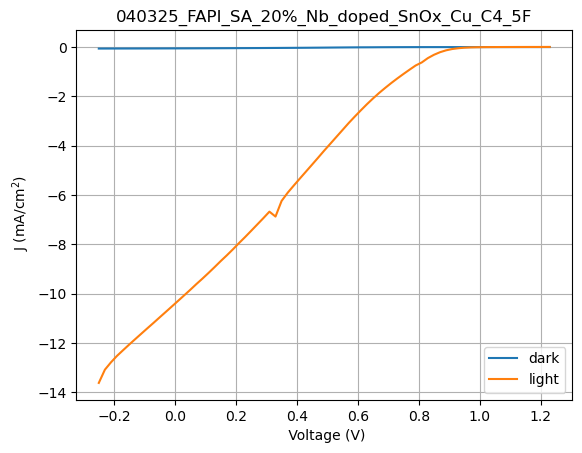

LabJack U3 setup: 
{'FirmwareVersion': '1.46', 'BootloaderVersion': '0.27', 'HardwareVersion': '1.30', 'SerialNumber': 320096721, 'ProductID': 3, 'LocalID': 1, 'TimerCounterMask': 64, 'FIOAnalog': 15, 'FIODirection': 0, 'FIOState': 0, 'EIOAnalog': 0, 'EIODirection': 0, 'EIOState': 0, 'CIODirection': 0, 'CIOState': 0, 'DAC1Enable': 1, 'DAC0': 0, 'DAC1': 0, 'TimerClockConfig': 2, 'TimerClockDivisor': 256, 'CompatibilityOptions': 0, 'VersionInfo': 18, 'DeviceName': 'U3-HV'}
Starting IV scans:
set_lamp_state turned the lamp off
Lamp off
Sweep rate: -311.9 mV/sec
Switching the lamp state from off to on.
Lamp on
Sweep rate: -293.9 mV/sec
Switching the lamp state from on to off.
set_lamp_state turned the lamp off
Lamp off
Data collection is done!


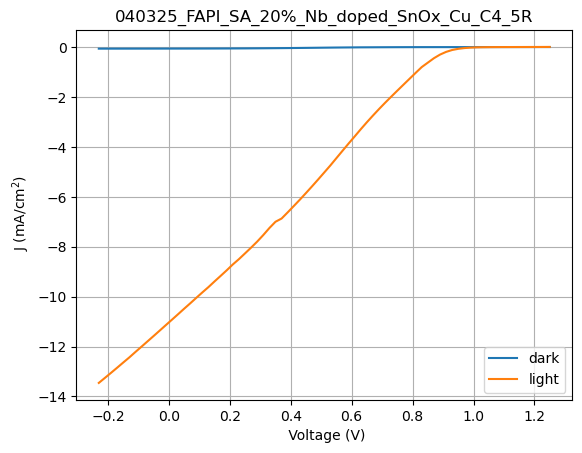

Data saved to: C:\Users\LabUser\OneDrive - Verde Technologies\Documents\data2\Pramod_041425/040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C4_5F_160403.csv
Plot saved to: C:\Users\LabUser\OneDrive - Verde Technologies\Documents\data2\Pramod_041425/040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C4_5F_160403.png
Data saved to: C:\Users\LabUser\OneDrive - Verde Technologies\Documents\data2\Pramod_041425/040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C4_5R_160403.csv
Plot saved to: C:\Users\LabUser\OneDrive - Verde Technologies\Documents\data2\Pramod_041425/040325_FAPI_SA_20%_Nb_doped_SnOx_Cu_C4_5R_160403.png
I_ph = 0.805 suns
V_oc = 1.017 V
mpp = 0.330 V
J_sc = 10.409 mA/cm^2
R_sh =  89.5 Ω-cm^2
R_ser = 8718.72 Ω-cm^2
FF = 21.428%
PCE =  2.27%
Appended parameters to: C:\Users\LabUser\OneDrive - Verde Technologies\Documents\data2\Pramod_041425\parameters_041425
four_wire_mode = False
Inserting data into table "crf3d_jv_test_datas".
I_ph = 0.805 suns
V_oc = 1.056 V
mpp = 0.450 V
J_sc = 11.034 mA/cm^2
R_sh =  92.3 Ω-cm^2
R_

In [366]:
### 5.1 ###
########################## This is the main script. ###################################################
########################## Double check your parameters before you run it! ############################
########################## Also make sure the Keithley unit was discovered and it is responding.#######
#######################################################################################################
#
# Single scan includes dark and light sweeps, and may also include both forward and reverse sweeps.
# Single scan has priority over timeseries.
if (do_single_scan == True):
    numscans = 1
elif (do_timeseries == True):
    numscans = int(np.ceil(3600*timeseries_duration/timeseries_interval)) + 1
    print("numscans = ", numscans)
else:
    numscans = 0 # If do_single_scan and do_timeseries are both False, this code block does nothing.
#
# Create an instance of the JVScanDataverseTable with environment-specific parameter data.
jvscan_table = JVScanDataverseTable(
    crm_url = crm_url,
    table_name = JV_scan_table_logical_name, # Logical names are specific to a particular table.
    col_logical_names =  col_logical_names,
    image_column_name = image_column_name
)
#
# The main loop starts here.
#
for myint in range(numscans):
    # do the scan
    if (direction == "forward" or direction == "both"):
        fig_F, df_F = Keithley.dark_light_IVsweep(startv, stopv, stepv, rate=sweep_rate, 
                                          area=cellarea, plottitle=samplename+"_"+cellnumber+"F", 
                                                  verbose=verbose, labjack=labjack, burnintime=burnintime,
                                                  do_dark=do_dark_sweeps, mpp_tracking_mode=mpp_tracking_mode,
                                                  four_wire_mode=four_wire)
    if(direction == "reverse" or direction == "both"):
        fig_R, df_R = Keithley.dark_light_IVsweep(stopv, startv, -stepv, rate=sweep_rate, 
                                          area=cellarea, plottitle=samplename+"_"+cellnumber+"R", 
                                                  verbose=verbose, labjack=labjack, burnintime=burnintime,
                                                  do_dark=do_dark_sweeps, mpp_tracking_mode=mpp_tracking_mode,
                                                  four_wire_mode=four_wire)
    # record the current time
    timenow = datetime.now()
    timenowstr = timenow.strftime("%H%M%S")    
    datetodaystr = today.strftime("%m%d%y")
    # Save the data
    if (savedata != 'no'):
        if (direction == "forward" or direction == "both"):
            scan_data_path_F, image_data_path_F = Keithley.save_data_and_plot(df_F, fig_F, path = path, samplename = samplename, 
                                cellnumber = cellnumber+"F", timenowstr = timenowstr)
        if(direction == "reverse" or direction == "both"):
            scan_data_path_R, image_data_path_R = Keithley.save_data_and_plot(df_R, fig_R, path = path, samplename = samplename, 
                                cellnumber = cellnumber+"R", timenowstr = timenowstr)
    else:
        print("Data NOT saved.")
        
    ####  Calculate and save the PV parameters.
    # Calculate V_OC, J_SC, R_Sh, R_Ser, FF, PCE and save them to a common "parameters" file. Also insert intothe Dataverse table.
    if (direction == "forward" or direction == "both"):
        par_df_new_F = jvscan_table.calc_and_save_parameters_db(df_F, form_responses_dictionary, Keithley, image_data_path_F, scan_data_path_F, 
                                path = path, temp_c=temp_c, hum_pct=hum_pct, four_wire=four_wire,
                                samplename = samplename, cellnumber = cellnumber, scantype = "F", 
                                timenowstr = timenowstr, datetodaystr = datetodaystr,
                                saveparameters = saveparameters, verbose=verbose,                         
                                timeseries = do_timeseries, base_t = base_t, I_ph = I_ph,
                                mpp_tracking_mode=mpp_tracking_mode) 
    if(direction == "reverse" or direction == "both"):
        par_df_new_R = jvscan_table.calc_and_save_parameters_db(df_R, form_responses_dictionary, Keithley, image_data_path_R, scan_data_path_R, 
                                path = path, temp_c=temp_c, hum_pct=hum_pct, four_wire=four_wire,
                                samplename = samplename, cellnumber = cellnumber, scantype = "R", 
                                timenowstr = timenowstr, datetodaystr = datetodaystr,
                                saveparameters = saveparameters, verbose=verbose,                         
                                timeseries = do_timeseries, base_t = base_t, I_ph = I_ph,
                                mpp_tracking_mode=mpp_tracking_mode)  
 
    
    # Delay before the next sweep.
    # tqdm displays a progress bar during the sleep time.
    print(f"\nSweep {(myint+1)} of {numscans} is complete!")
    print("Elapsed time: {:.1f}\n".format(time.time()-base_t))
    if (myint < (numscans-1)):
        for i in tqdm(range(timeseries_interval)):
            time.sleep(0.99)

#### Code under development

In [ ]:
# to do: implementation of stabilized scan.  

# # Estimate V_oc from the average of forward and reverse sweep values.
# stab_V_oc_estimate = (par_df_new_R["V_oc(V)"].loc[0] + par_df_new_F["V_oc(V)"].loc[0])/2

# # Estimate I_sc from several individual measurements.
# startv = 0.0; stopv = 0.002; stepv = 0.0019
# print("I_sc (A):")
# for myint in range(5):
#     dfl = Keithley.IVsweep(startv, stopv, stepv, rate="fast",final_V=str(startv), 
#                     mpp_tracking_mode=True, four_wire_mode=False)
#     print(dfl["I(A)"].iloc[0])
#     time.sleep(1)
# stab_I_sc = dfl["I(A)"].iloc[0]



#####  6. You can still view the results if you ran the scan with verbose=0. Use the code block below.

Note: This will only display result for the last scan done.

In [ ]:
# # Display the single scan results or for the last scan of a timeseries.
# if (True):
#     if(direction == "reverse"):
#         print("\n", par_df_new_R)
#         display(fig_R)
#     elif (direction == "both"):
#         print("\n", par_df_new_F)
#         print("\n", par_df_new_R)
#         display(fig_F)
#         display(fig_R)
#     else:
#         print("\n", par_df_new_F)
#         display(fig_F)